# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
!pip install progressbar

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [4]:
import pandas as pd
import numpy as np
import math, json, re, os

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from clean_data import * 
from exploratory_data_analysis import *

%matplotlib inline

## Read data from JSON file

* Check dataframe and familiarise with data 

In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [7]:
portfolio.info() # No missing values in portfolio dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
profile.info() # missing values in profile dataframe (gender and income)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
profile.shape[0] - profile.isnull().sum() 

gender              14825
age                 17000
id                  17000
became_member_on    17000
income              14825
dtype: int64

Profile dataframe has missing values (gender and income) 

In [10]:
transcript.info() # No missing values in transcript dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
# offer master database 
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
# Customer master 
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
portfolio = clean_portfolio()
portfolio

,offerid,difficulty,durationdays,reward,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,0,1,1,0,1


In [15]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [16]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
# '%' sex split where gender is specified
profile['gender'].value_counts()*100/ profile['gender'].count()

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [18]:
# '%' sex split as per overall profile count 
profile['gender'].value_counts()*100/ profile.count()[1]

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64

## EDA

<b> Compute summary customer profile attribute statistics when customer income is not specified </b>
* Some customer Income is not specified and some customer Age is specified as 118, looks high than normal - Needs an investigation


In [19]:
profile[profile['income'].isnull()][['age', 'income']].describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


<B> Compute summary customer profile attribute statistics when customer income is specified

In [20]:
profile[profile['income'].notnull()][['age', 'income']].describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


<B> Evaluate what year a customer became a rewards member </b>
    
* Over the years customer membership has increase except in 2018 

In [21]:
#Convert string date to date and time and check membership trend
became_member_on = profile['became_member_on'].apply(convert_to_datetime)

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

<b> Evaluate which month a customer became a rewards member</b>

* membership registration between month of Aug and Jan higher than in other months, very well looks to be a seasonality

In [22]:
start_month = became_member_on.apply(lambda elem: elem.month).value_counts()
start_month *= 100 / start_month.sum()
start_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

Clean the customer profile data


* Remove customers details with missing income and gender  is missing
* Change the name of the 'id' column to 'customerid'
* Transform the 'became_member_on' column to a datetime object
* One hot encode a customer's membership start year
* One hot encode a customer's age range
* Transform a customer's gender from a character to a number

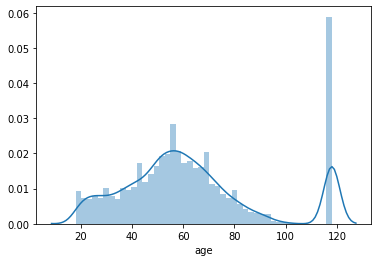

In [23]:
sns.distplot(profile['age'])

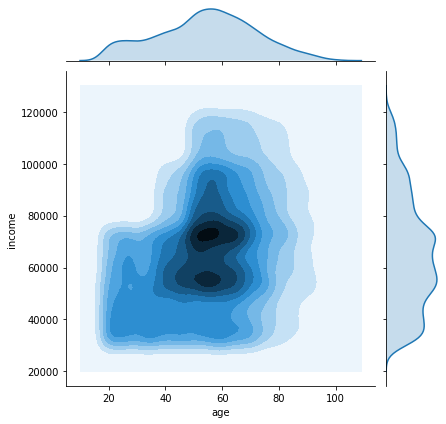

In [24]:
sns.jointplot(x='age', y ='income', data=profile, kind='kde', dropna=True)

In [25]:
(profile,
 gender_integer_map) = clean_profile()

print("Number of user profiles: %d" % (profile.shape[0]))

Number of user profiles: 14613


<b> Print the first five rows of the preprocessed (i.e. clean) customer profile data

In [26]:
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [27]:
# Check year wise / gender registration

#chk_gender_year = profile.groupby('gender')[[2014, 2015, 2016, 2017, 2018]].sum()
#chk_gender_year

In [28]:
#pd.pivot_table(profile, index=[2014, 2015, 2016, 2017, 2018], columns='gender', 
#                    values='income', aggfunc=np.mean, dropna=True)

In [29]:
#profile.groupby('gender')[2014, 2015, 2016, 2017, 2018, 'income'].mean()

<b> Print the mapping of customer gender string to an integer value

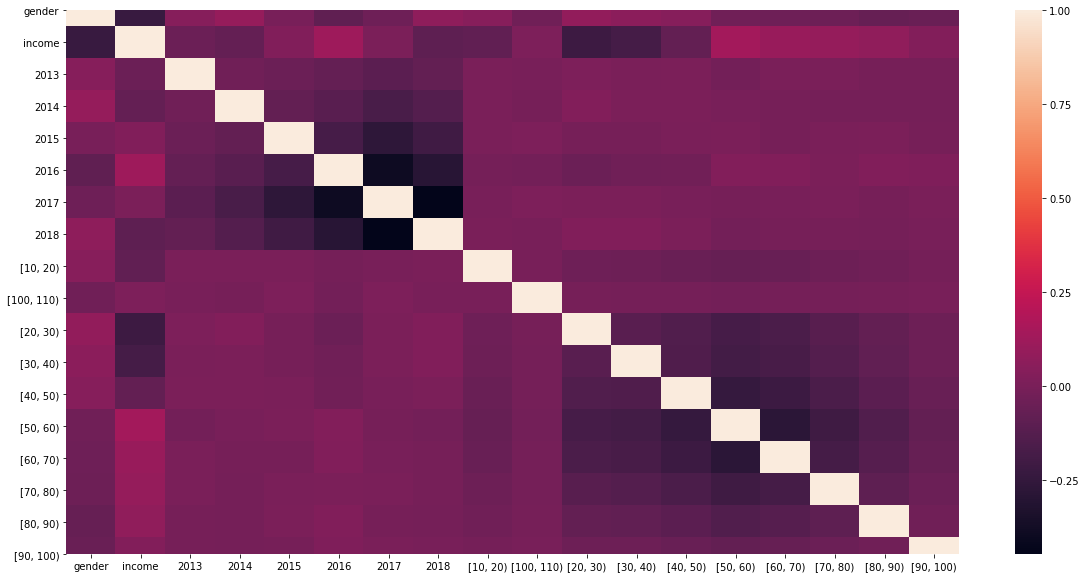

In [30]:
plt.figure(figsize=(20,10))
sns.heatmap(profile.corr())

In [31]:
print(gender_integer_map)

{'F': 0, 'M': 1}


<b> Plot Income Distribution as a Function of Gender </b>
    
Results suggest that the minimum income for both male and female customer are same, whereas average income of male is lower than female, but female income have few outliers on higher side.

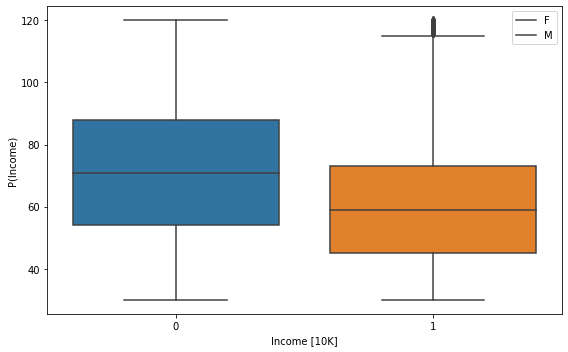

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot('gender', profile['income']*1E-3, data = profile)
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.legend(gender_integer_map)
plt.tight_layout()

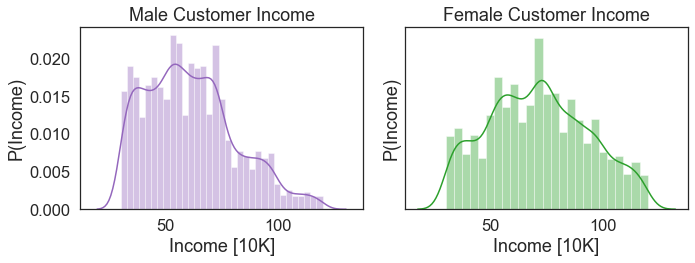

In [33]:
male_customers = profile[profile['gender'] == 1]
female_customers = profile[profile['gender'] == 0]

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2,
                       sharex=True, sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[4], kde=True)
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3, 
             color=current_palette[2], kde=True)
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

<b> Visualise Membership Start Year Statistics </b>

The results suggest that most customers recently joined the Starbucks rewards program. These results also suggest that there are more male customers than female customers.


/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0, 0.5, 'Count')

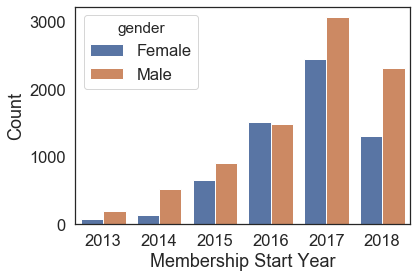

In [34]:
# Plot 
membership_date = initialize_membership_date(profile, gender_integer_map)

sns.barplot(x='startyear', y='count', hue='gender', data=membership_date, capsize=.2)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

<b> Check customer gender distribution

In [35]:
(membership_date.groupby('gender')['count'].sum() / membership_date['count'].sum())

gender
Female    0.419421
Male      0.580579
Name: count, dtype: float64

### Evaluate Age Range Statistics

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

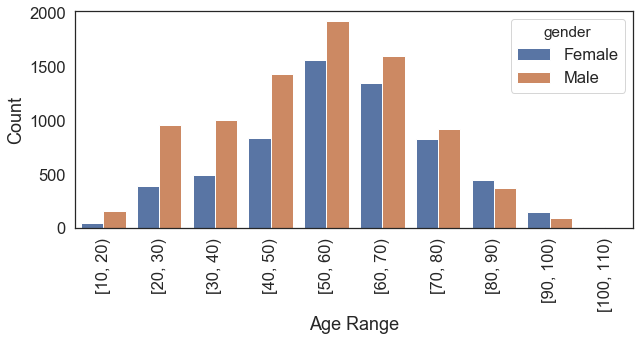

In [36]:
age_range = init_agerange(profile,
                          gender_integer_map)

plt.figure(figsize=(10, 4))
sns.barplot(x='agerange', y='count', hue='gender', data=age_range)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

In [37]:
(age_range.groupby('agerange')['count'].sum() / age_range['count'].sum()).map(lambda n: '{:,.2%}'.format(n))

agerange
[10, 20)       1.40%
[100, 110)     0.11%
[20, 30)       9.26%
[30, 40)      10.29%
[40, 50)      15.53%
[50, 60)      23.85%
[60, 70)      20.20%
[70, 80)      12.02%
[80, 90)       5.62%
[90, 100)      1.72%
Name: count, dtype: object

In [38]:
(age_range.groupby(['agerange','gender'])['count'].sum() / age_range['count'].sum()).map(lambda n: '{:,.2%}'.format(n))

agerange    gender
[10, 20)    Female     0.31%
            Male       1.09%
[100, 110)  Female     0.10%
            Male       0.01%
[20, 30)    Female     2.69%
            Male       6.57%
[30, 40)    Female     3.39%
            Male       6.90%
[40, 50)    Female     5.71%
            Male       9.81%
[50, 60)    Female    10.68%
            Male      13.17%
[60, 70)    Female     9.24%
            Male      10.96%
[70, 80)    Female     5.69%
            Male       6.33%
[80, 90)    Female     3.08%
            Male       2.54%
[90, 100)   Female     1.06%
            Male       0.66%
Name: count, dtype: object

In [39]:
print (age_range.pivot(index='agerange', columns='gender', values='count')
         .reset_index())

gender    agerange  Female  Male
0         [10, 20)      45   160
1       [100, 110)      14     2
2         [20, 30)     393   960
3         [30, 40)     495  1008
4         [40, 50)     835  1434
5         [50, 60)    1560  1925
6         [60, 70)    1350  1602
7         [70, 80)     832   925
8         [80, 90)     450   371
9        [90, 100)     155    97


###  Transaction data

* Customer transaction record attributes
 * event (str) - Record description (i.e. transaction, offer received, offer viewed, etc.)
 * person (str) - Customer id
 * time (int) - Time in hours. The data begins at time t=0
 * value - (dict of strings) - Either an offer id or transaction amount depending on the record

* Customer transaction data EDA conclusions
 * Need to separate offer and customer purchase data
 * Results suggest ~ 45 % of the events are customers purchases and ~ 55% of the events describe customer offers

<b>Print the first five rows of the transaction data</b>

In [40]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [41]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


<b> Compute the event type distribution

In [42]:
transcript['event'].value_counts() / transcript['event'].count()

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [43]:
list(zip(transcript['event'].value_counts()))

[(138953,), (76277,), (57725,), (33579,)]

In [44]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


<b> Compute the percentage of customer transaction and offer events

In [45]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


### Clean the transaction data

1. Rename 'person' column to 'customerid' and remove customer details that are not present in customer profile dataframe
2. Convert time variable units from hours to days
3. Change the name of the 'time' column to 'timedays'
4. Create a DataFrame that describes offers
 * Create an offerid column
 * Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
 * One hot encode customer offer events
5. Create a DataFrame that describes customer transaction events
 * Parse customer transaction values

In [46]:
offer_data, transaction = clean_transcript(profile)

Percentage of transactions removed: 12.31 %


In [47]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


<b> Print the first five rows of the transformed customer transaction data

In [48]:
transaction.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


### Combine transaction, demographic and offer data

For each customer, apply the following algorithm:

1. join customer's profile, with offer and transaction
2. Initialize DataFrames that describe when a customer receives, views, and completes an offer
3. Iterate over each offer a customer receives
 * Initialize the current offer id
 * Look-up a description of the current offer
 * Initialize the time period when an offer is valid
 * Initialize a Boolean array that select customer transactions that fall within the valid offer time window
 * Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)
 * Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
 * Determine whether the current offer was successful
  * For an offer to be successful a customer has to view and complete it
 * Select customer transactions that occurred within the current offer valid time window
 * Initialize a dictionary that describes the current customer offer
 * Update a list of dictionaries that describes the effectiveness of offers to a specific customer


Once all customer transactions have been evaluated, convert the resulting list of dictionaries into a pandas DataFrame.

In [49]:
profile.columns

Index(['customerid',     'gender',     'income',         2013,         2014,
               2015,         2016,         2017,         2018,   '[10, 20)',
       '[100, 110)',   '[20, 30)',   '[30, 40)',   '[40, 50)',   '[50, 60)',
         '[60, 70)',   '[70, 80)',   '[80, 90)',  '[90, 100)'],
      dtype='object')

In [50]:
clean_data_csvfile = "clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
    column_ordering = ['time', 'offerid', 'customerid', 'totalamount',
                   'offersuccessful', 'difficulty', 'durationdays',
                   'reward', 'bogo', 'discount', 'informational',
                   'email', 'mobile', 'social', 'web', 'gender',
                   'income', '2013', '2014', '2015', '2016', '2017', '2018',
                    '[10, 20)', '[20, 30)',
                    '[30, 40)', '[40, 50)','[50, 60)', '[60, 70)',
                    '[70, 80)', '[80, 90)','[90, 100)', '[100, 110)']
else:
    customerid_list = offer_data['customerid'].unique()
    cnter = 0
    clean_data = []
    bar = progressbar.ProgressBar(maxval=len(customerid_list), 
                widgets=[progressbar.Timer(), progressbar.Bar('='), ' ',  
                         progressbar.Percentage(), ' ', progressbar.ETA()])
    bar.start()
    for idx in range(len(customerid_list)):
        clean_data.extend(create_combined_records(customerid_list[idx],
                                                      portfolio, profile,
                                                      offer_data, transaction))
        cnter+=1 
        bar.update(cnter)

    bar.finish()
    
    column_ordering = ['time', 'offerid', 'customerid', 'totalamount',
                   'offersuccessful', 'difficulty', 'durationdays',
                   'reward', 'bogo', 'discount', 'informational',
                   'email', 'mobile', 'social', 'web', 'gender',
                   'income', 2013, 2014, 2015, 2016, 2017, 2018,
                    '[10, 20)', '[20, 30)',
                    '[30, 40)', '[40, 50)','[50, 60)', '[60, 70)',
                    '[70, 80)', '[80, 90)','[90, 100)', '[100, 110)']

#

clean_data = pd.DataFrame(clean_data)

# Initialize a list that describes the desired output DataFrame
# column ordering

clean_data = clean_data[column_ordering]

clean_data = clean_data.sort_values('time')

clean_data.to_csv(clean_data_csvfile, index=False)

clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

Elapsed Time: 0:10:33|=====================================| 100% Time: 0:10:33


KeyError: "['bogo'] not in index"

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(clean_data.corr())

#### Above correlation plot suggest there are few positive influcing parameters

### Split the data into training and testing data

In [ ]:
class_label_name = 'offersuccessful'
random_state = 101
variables = clean_data.drop(columns=[class_label_name])
class_label = clean_data.filter([class_label_name])

(X_train, X_test, y_train, y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.3,
                            random_state=random_state)

variable_names = variables.columns[2:]

offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

#### Print offer effectiveness data attributes

#### Initialize a DataFrame that describes the training data (customer data only)

In [ ]:
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[class_label_name])
training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

training_data = pd.concat([training_offerid, training_variables,
                           training_labels], axis=1)

training_data.head()

#### Analyze Offer Statistics

These results suggest that distribution of offers in the simulated Starbucks mobile application data is relatively uniform.

Offer sucess is ranging between 6.188% to 74.669% with a mean of 46.942


In [ ]:
percent_success = initialize_percent_success(portfolio, training_data)
percent_success

In [ ]:
percent_success['percentsuccess'].describe()

In [ ]:
plt.figure(figsize=(18,6))
sns.heatmap(percent_success.corr())

#### Generate a plot that illustrates:

* How many customers were provided a specific offer
* Offer sucess rate (% success)

In [ ]:
f, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer #')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1,
           percent_success['percentsuccess'],
           linewidth=3)
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer #')
ax[1].set_ylabel('Percent Success')
plt.tight_layout()

#### Transform variables

* Dataset includes both numeric and one hot encoded categorical variables. Need to apply minimum / maximum scaling to numeric variables to avoid model bias. 
  * Use scikit learn feature scaling

In [ ]:
variables_to_scale = ['difficulty', 'durationdays', 'reward', 'income']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))

    transformed_values =\
        min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))

    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    
    transformed_values =\
        min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    X_test[:, column_idx] = transformed_values.reshape(1, -1)

### Quick data check, cleanup and Correlation 

In [ ]:
clean_data.columns

In [ ]:
EDA_corr_Check = pd.get_dummies(clean_data['offerid'], drop_first=True)
EDA_corr_Check = pd.concat([clean_data, EDA_corr_Check], axis=1)
EDA_corr_Check.drop(['offerid'], axis=1, inplace=True)
EDA_corr_Check.head()

In [ ]:
plt.figure(figsize=(24,8))
sns.heatmap(EDA_corr_Check.corr()>.6)

## Analysis Phase

#### Customer Statistics

- General trends
 * Offer success increases with average customer income and age
  * majority of customer is in the age group of 20 and 80 amd majority between 40 and 70. This trend is much understood with income and working population trend
 * For unsuccessful offers the percentage of male customers is typically significantly higher than the percentage of female customers
 * Offers are less successful for customers who created an account on the Starbucks rewards mobile application in 2018 (membership start year)



<b>offerid: fafdcd668e3743c1bb461111dcafc2a4 </b>
* Offer successful
  - Average customer income: 66281.1
  - Average customer age: 55.9 years
  - Percentage of male customers: 54.47%
  - Percentage of female customers: 45.52%

* Offer unsuccessful
  - Average customer income: 57559,3
  - Average customer age: 52.9 years
  - Percentage of male customers: 69.47%
  - Percentage of female customers: 30.52%

<b><u>Summary</u>:</b> 2015, 2016 and 2017 members are more likely to opt for offer, whereas 2018 joined members are more inclined to reject

In [ ]:
explore_customer_offer(0, percent_success, training_data, gender_integer_map)

<b> offerid: 2298d6c36e964ae4a3e7e9706d1fb8c2 </b>

- Offer successful
 - Average customer income: 65693.0
 - Average customer age: 55.4 years
 - Percentage of male customers: 54.50%
 - Percentage of female customers: 45.49%
 
- Offer unsuccessful
 - Average customer income: 59768.6
 - Average customer age: 53 years
 - Percentage of male customers: 69.64%
 - Percentage of female customers: 30.35%

<b><u>Summary</u>:</b> 2015, 2016 and 2017 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(1, percent_success, training_data, gender_integer_map)

<b> offerid: f19421c1d4aa40978ebb69ca19b0e20d </b>
- Offer successful
 - Average customer income: 67313.8
 - Average customer age: 56.5 years
 - Percentage of male customers: 52.28%
 - Percentage of female customers: 47.71%

- Offer unsuccessful
 - Average customer income: 59179.6.7
 - Average customer age: 53.1 years
 - Percentage of male customers: 64.62%
 - Percentage of female customers: 35.37%
  
<b><u>Summary</u>:</b> 2015, 2016 and 2017 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(2, percent_success, training_data, gender_integer_map)

<b> offerid: ae264e3637204a6fb9bb56bc8210ddfd </b>

- Offer successful
 - Average customer income: 68009.2
 - Average customer age: 56.2 years
 - Percentage of male customers: 50.35%
 - Percentage of female customers: 49.64%
 - Higher percentage of 2015 & 2016 membership start years

- Offer unsuccessful
 - Average customer income: 58773.0
 - Average customer age: 52.6 years
 - Percentage of male customers: 68.15%
 - Percentage of female customers: 31.84%
 - Higher percentage of 2018 membership start year
 
<b><u>Summary</u>:</b> 2015, 2016, 2017 joined members are likely to opt for the offer for 2018 offer adaption is high than other 3 offers, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(3, percent_success, training_data, gender_integer_map)

<b> offerid: 4d5c57ea9a6940dd891ad53e9dbe8da0 </b>

- Offer successful
 - Average customer income: 69893.6
 - Average customer age: 56.7 years
 - Percentage of male customers: 51.57%
 - Percentage of female customers: 48.42%

- Offer unsuccessful
 - Average customer income: 57751.5
 - Average customer age: 52.8 years
 - Percentage of male customers: 68.50%
 - Percentage of female customers: 31.49%
 
<b><u>Summary</u>:</b> 2015, 2016, 2017 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(4, percent_success, training_data, gender_integer_map)

<b> offerid: 9b98b8c7a33c4b65b9aebfe6a799e6d9 </b>

- Offer successful
 - Average customer income: 67761.2
 - Average customer age: 56.3 years
 - Percentage of male customers: 53.19%
 - Percentage of female customers: 46.80%
 
- Offer unsuccessful
 - Average customer income: 59837.6
 - Average customer age: 53,6 years
 - Percentage of male customers: 63.84%
 - Percentage of female customers: 37.15%
 
<b><u>Summary</u>:</b> 2015, 2016, 2017 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(5, percent_success, training_data, gender_integer_map)

<b> offerid: 2906b810c7d4411798c6938adc9daaa5 </b>

- Offer successful
 - Average customer income: 66340.5
 - Average customer age: 55.8 years
 - Percentage of male customers: 52.10%
 - Percentage of female customers: 47.89%

- Offer unsuccessful
 - Average customer income: 61272.3
 - Average customer age: 53.9 years
 - Percentage of male customers: 62.71%
 - Percentage of female customers: 37.28%
 
<b><u>Summary</u>:</b> 2015, 2016, 2017 and 2018 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(6, percent_success, training_data, gender_integer_map)

<b> offerid: 0b1e1539f2cc45b7b9fa7c272da2e1d7 </b>

- Offer successful
 - Average customer income: 67708.8
 - Average customer age: 56.3 years
 - Percentage of male customers: 52.45%
 - Percentage of female customers: 47.54%

- Offer unsuccessful
 - Average customer income: 60124.7
 - Average customer age: 53.9 years
 - Percentage of male customers: 61.76%
 - Percentage of female customers: 38.23%
 
<b><u>Summary</u>:</b> 2015, 2016, 2017 and 2018 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(7, percent_success, training_data, gender_integer_map)

<b> offerid: 3f207df678b143eea3cee63160fa8bed </b>

- Offer successful
 - Average customer income: 67863.8
 - Average customer age: 57.3 years
 - Percentage of male customers: 50.14%
 - Percentage of male customers: 49.85%

- Offer unsuccessful
 - Average customer income: 62980.9
 - Average customer age: 54.6 years
 - Percentage of male customers: 58.82%
 - Percentage of male customers: 41.17%

<b><u>Summary</u>:</b> 2015, 2016, 2017 and 2018 joined members are likely to opt for the offer, wheras for 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(8, percent_success, training_data, gender_integer_map)

<b> offerid: 5a8bc65990b245e5a138643cd4eb9837</b>

- Offer successful
 - Average customer income: 64481.6
 - Average customer age: 56.8 years
 - Percentage of male customers: 57.43%
 - Percentage of female customers: 42.56%

- Offer unsuccessful
 - Average customer income: 63835.8
 - Average customer age: 54.6 years
 - Percentage of male customers: 56.85%
 - Percentage of female customers: 43.14%
 
<b><u>Summary</u>:</b> 2015, 2016, 2017 and 2018 joined members are likely to opt for the offer, wheras for 2015 and 2017 verdit is split and 2018 are more likely to reject

In [ ]:
explore_customer_offer(9, percent_success, training_data, gender_integer_map)

### Predictive Modeling

#### Evaluate naive predictor performance
- A naive predictor assumes that all customer offers were successful

In [ ]:
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

<b> Naive predictor</b>
 - Accuracy: 0.469 & F1-score: 0.639

In [ ]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,
                     beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

<b> Define model performance evaluation function

In [ ]:
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

<b> Evaluate Logistic Regression Model Performance

In [ ]:
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

<b> Construct Random Forest Model</b>

- Perform random search of model hyperparameter space
- Resuls suggest that a random forest model's accuracy and f1-score is better than the naive predictor

 - Accuracy
   - Naive predictor: 0.469
   - Logistic regression: 0.721
 - F1-score
   - Naive predictor: 0.639
   - Logistic regression: 0.716

In [ ]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt', 'log2']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'bootstrap': [True, False],
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

<b> Evalaute Random Forest Model Performance

In [ ]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

<b> Model Accuracy and F1 score </b>

- Perform random search of model hyperparameter space
- Resuls suggest that a random forest model's accuracy and f1-score is better than the naive predictor

 - Accuracy
   - Naive predictor: 0.469
   - Logistic regression: 0.721
   - Random Forest: 0.736
 - F1-score
   - Naive predictor: 0.639
   - Logistic regression: 0.716
   - Random Forest: 0.730

<b> Plot Estimated Feature Importance</b>

* "Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric

* These results suggest that the top five features contibuting to 71.16% feature importance 
 1. Offer reward
 2. Offer duration
 3. Offer difficulty (how much money a customer must spend to complete an offer)
 4. Membership year - specifically in the year 2018
 5. Customer income

In [ ]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("coolwarm", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

<b> Print the top 10 features sorted based on their estimated importance

In [ ]:
feature_importance.head(n=10)

In [ ]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

if os.path.exists(gb_model_path):
    gb_random = load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

    gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    gb_random.fit(X_train, y_train)

    dump(gb_random, gb_model_path)


In [ ]:
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

<b> Evaluate Gradient Boosting Model Performance

In [ ]:
evaluate_model_performance(gb_random.best_estimator_,
                           X_train,
                           y_train)

#### Tune the best model
* Model ranking based on training data accuracy
 * RandomForestClassifier model accuracy: 0.736
 * GradientBoostingClassifier model accuracy: 0.737
 * LogisticRegression model accuracy: 0.721
 * Naive predictor accuracy: 0.469

* Model ranking based on training data F1-score
 * RandomForestClassifier model f1-score: 0.730
 * GradientBoostingClassifier model f1-score: 0.726
 * LogisticRegression model f1-score: 0.716
 * Naive predictor f1-score: 0.639
 
* Results suggest that the random forest model and gradient boosting classifier are very close with .001 in favour of gradient boosting classifier whereas when looked in relation to F1-Score then best training data accuracy and F1-score

Bias and variance are two characteristics of a machine learning model. 
 - Bias refers to inherent model assumptions regarding the decision boundary between different classes. 
 - On the other hand, variance refers a model's sensitivity to changes in its inputs. 

A logistic regression model constructs a linear decision boundary to separate successful and unsuccessful offers. However,  exploratory analysis of customer demographics for each offer suggests that this decision boundary will be non-linear. Therefore, an ensemble method like random forest or gradient boosting should perform better.

Both random forest and gradient boosting models are a combination of multiple decision trees. A random forest classifier randomly samples the training data with replacement to construct a set of decision trees that are combined using majority voting. In contrast, gradient boosting iteratively constructs a set of decision trees with the goal of reducing the number of misclassified training data samples from the previous iteration. A consequence of these model construction strategies is that the depth of decision trees generated during random forest model training are typically greater than gradient boosting weak learner depth to minimize model variance. Typically, gradient boosting performs better than a random forest classifier. However, gradient boosting may overfit the training data and requires additional effort to tune. A random forest classifier is less prone to overfitting because it constructs decision trees from random training data samples. Also, a random forest classifier's hyperparameters are easier to optimize.

In [ ]:
model_performance = []

classifier_type = ['naivepredictor',
                   'logisticregression',
                   'randomforest',
                   'gradientboosting']

model_performance.append((naive_predictor_accuracy,
                          naive_predictor_f1score))

model_performance.append(evaluate_model_performance(lr_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(rf_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(gb_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance = pd.DataFrame(model_performance,
                                 columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,
                               columns=['classifiertype'])

model_performance = pd.concat([classifier_type, model_performance],
                              axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

<b> Print the Best Model's Hyperparameters

In [ ]:
print(rf_random.best_estimator_)

<b> Refine Best Model</b> 

* Refine model hyperparameter space
 * Hyperparameter Tuning the Random Forest in Python

In [ ]:
rf_clf = RandomForestClassifier(random_state=random_state)

Finding the best fit - 375 to 415 minutes to execute

In [ ]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [300, 350, 400, 450, 500],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split,
                  'random_state': [random_state]}

    grid_obj = GridSearchCV(rf_clf,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=3,
                            verbose=2)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf,
                           X_train,
                           y_train)

<b> Print the Refined Random Forest Model's Hyperparameters

In [ ]:
best_clf

<b> Evaluate Test Data Performance

In [ ]:
evaluate_model_performance(best_clf,
                           X_test,
                           y_test)

#### Conclusion

This analysis suggests that a random forest model has the best training data accuracy and F1-score. Refined random forest model hyperparameters using a grid search. Analysis suggests that the resulting random forest model has an training data accuracy of 0.753 and an F1-score of 0.746. The test data set accuracy of .735 and F1-score of .730 suggests that the random forest modeldid not overfit the training data.

"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training.

My analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top five features based on their importance are:
1. Offer reward
2. Offer duration
3. Offer difficulty (how much money a customer must spend to complete an offer)
4. Membership year - specifically in the year 2018
5. Customer income  

Since the top three features are associated with an customer offer, it is possible to further improve the performance of a random forest model by creating features that describe an offer's success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.

## End ##